moved to big grid. detecting path and then moving car manually using website thing. we are detecting path and april tag independently

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import grey_dilation
from pupil_apriltags import Detector
import time

CELL_SIZE = 10
DETECTOR = Detector(families='tag36h11')


In [2]:
def pixel_to_grid(pixel, cell_size=CELL_SIZE):
    return (pixel[1] // cell_size, pixel[0] // cell_size)

def grid_to_pixel(grid, cell_size=CELL_SIZE):
    return (grid[1] * cell_size + cell_size // 2, grid[0] * cell_size + cell_size // 2)

def resize_for_pathfinding(mask, factor):
    small = cv2.resize(mask, (mask.shape[1] // factor, mask.shape[0] // factor), interpolation=cv2.INTER_NEAREST)
    return (small > 0).astype(np.uint8)

def inflate_obstacles(grid, inflation_radius=1):
    return grey_dilation(grid, size=(2 * inflation_radius + 1, 2 * inflation_radius + 1))


In [3]:
def detect_start_end_obstacles(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Yellow for start
    yellow_mask = cv2.inRange(hsv, (15, 80, 80), (40, 255, 255))


    # Pink for end
    pink_mask = cv2.inRange(hsv, (160, 100, 120), (175, 255, 255))  # end before 160



    # Red obstacles (both ends of HSV range)
    lower_red1 = cv2.inRange(hsv, (0, 120, 50), (10, 255, 255))
    upper_red2 = cv2.inRange(hsv, (160, 120, 50), (165, 255, 255))  # shrink from 180 to 170
    red_mask = cv2.bitwise_or(lower_red1, upper_red2)


    # Green obstacles
    green_mask = cv2.inRange(hsv, (40, 40, 40), (80, 255, 255))

    # Combine red and green masks for obstacles
    obstacle_mask = cv2.bitwise_or(red_mask, green_mask)

    def find_centroid(mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            M = cv2.moments(largest)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                return (cx, cy)
        return None

    start = find_centroid(yellow_mask)
    end = find_centroid(pink_mask)

    return start, end, obstacle_mask


In [4]:
def heuristic(a, b):
    # Euclidean gives smoother paths with diagonals
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

def astar(grid, start, end):
    import heapq
    neighbors = [
        (0, 1), (1, 0), (0, -1), (-1, 0),
        (1, 1), (-1, -1), (1, -1), (-1, 1)
    ]
    
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, end)}
    oheap = [(fscore[start], start)]

    while oheap:
        _, current = heapq.heappop(oheap)

        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        close_set.add(current)

        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue
            else:
                continue

            tentative_g = gscore[current] + heuristic(current, neighbor)

            if neighbor in close_set and tentative_g >= gscore.get(neighbor, float('inf')):
                continue

            if tentative_g < gscore.get(neighbor, float('inf')):
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g
                fscore[neighbor] = tentative_g + heuristic(neighbor, end)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return []


In [5]:
def visualize_grid(grid, start=None, end=None):
    import matplotlib.pyplot as plt
    vis = (grid * 255).astype(np.uint8)

    if start:
        vis[start[0], start[1]] = 100  # gray for start
    if end:
        vis[end[0], end[1]] = 200  # lighter gray for end

    plt.imshow(vis, cmap='gray')
    plt.title("Grid with Obstacles, Start & End")
    plt.show()

Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: None
Start: (452, 363) End: (167, 91)


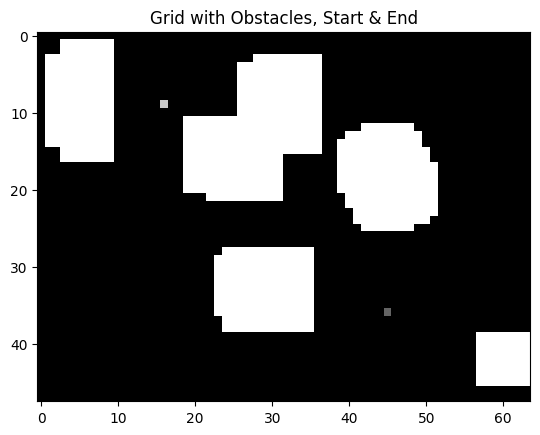

Path found! Exiting loop.


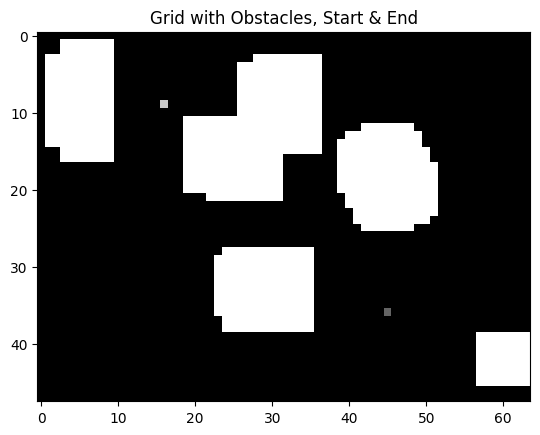

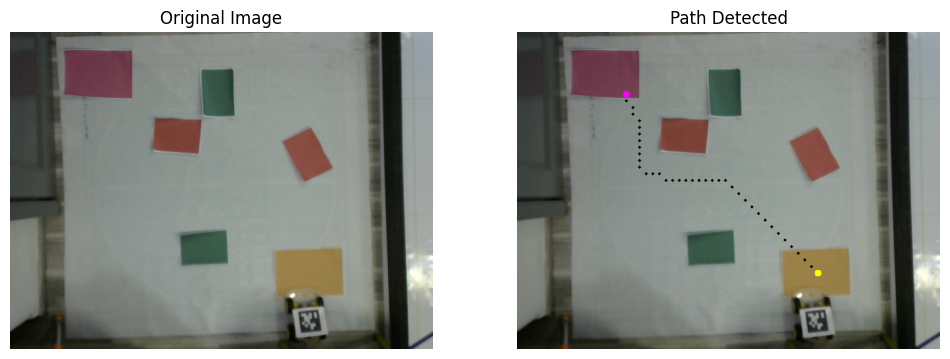

In [6]:
cap = cv2.VideoCapture(1)
path = []
path_pixels = []
frame = None

start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Camera read failed")
        continue

    start, end, obstacle_mask = detect_start_end_obstacles(frame)
    print("Start:", start, "End:", end)
    
    factor = 10
    if start and end:
        # Convert obstacle mask to binary grid
        obstacle_grid = resize_for_pathfinding(obstacle_mask, factor)

        # Convert pixel coordinates to grid
        start_grid = pixel_to_grid(start)
        end_grid = pixel_to_grid(end)

        # Clear start and end locations before inflation
        obstacle_grid[start_grid[0], start_grid[1]] = 0
        obstacle_grid[end_grid[0], end_grid[1]] = 0

        # Inflate obstacles
        inflated_grid = inflate_obstacles(obstacle_grid, inflation_radius=3)  # Increase radius if needed

        path = astar(inflated_grid, start_grid, end_grid)
        visualize_grid(inflated_grid, start_grid, end_grid)


        if path:
            print("Path found! Exiting loop.")
            path_pixels = [grid_to_pixel(pt) for pt in path]
            break
        else:
            print("No path found")

    # Optional: Add timeout
    if time.time() - start_time > 10:
        print("Timeout: Could not find valid path in time.")
        break

cap.release()

visualize_grid(inflated_grid, pixel_to_grid(start), pixel_to_grid(end))

# === Draw the path on the image ===
output = frame.copy()

# Draw the path with circles
for pt in path_pixels:
    cv2.circle(output, pt, 2, (0, 0, 0), -1)  # Black dots

# Start and end markers
if path_pixels:
    cv2.circle(output, path_pixels[0], 5, (0, 255, 255), -1)   # Yellow = Start
    cv2.circle(output, path_pixels[-1], 5, (255, 0, 255), -1)  # Magenta = End


# Show image with matplotlib (side-by-side original and path)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Path Detected")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [7]:
def get_direction_changes(path):
    if len(path) < 3:
        return []

    turns = []
    prev_dir = (path[1][0] - path[0][0], path[1][1] - path[0][1])
    
    for i in range(2, len(path)):
        curr_dir = (path[i][0] - path[i-1][0], path[i][1] - path[i-1][1])
        if curr_dir != prev_dir:
            turns.append(path[i-1])  # Turning point
        prev_dir = curr_dir

    return turns


In [8]:
turning_points = get_direction_changes(path)

print("Direction change points (grid):")
for pt in turning_points:
    print("→", pt)


Direction change points (grid):
→ (22, 31)
→ (22, 22)
→ (21, 21)
→ (21, 19)
→ (20, 18)
→ (13, 18)
→ (12, 17)
→ (11, 17)
→ (10, 16)


In [9]:
turning_pixels = [grid_to_pixel(pt) for pt in turning_points]
print("Direction change points (pixels):")
for pt in turning_pixels:
    print("→", pt)


Direction change points (pixels):
→ (315, 225)
→ (225, 225)
→ (215, 215)
→ (195, 215)
→ (185, 205)
→ (185, 135)
→ (175, 125)
→ (175, 115)
→ (165, 105)


In [10]:
def detect_apriltag(frame, target_id=0):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    results = DETECTOR.detect(gray)
    for r in results:
        if r.tag_id == target_id:
            center = tuple(map(int, r.center))
            return center
    return None

In [11]:

# 1. Collect robot positions (in pixels)
tag_path = []

cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    robot_pos = detect_apriltag(frame)
    display = frame.copy()

    # Draw maze path (static)
    for pt in path_pixels:
        cv2.circle(display, pt, 2, (0, 0, 0), -1)

    # Draw robot live position (and track it)
    if robot_pos:
        tag_path.append(robot_pos)  # save position
        cv2.circle(display, robot_pos, 6, (0, 0, 255), -1)

    # Draw start & end points
    if path_pixels:
        cv2.circle(display, path_pixels[0], 5, (0, 255, 0), -1)   # Start (green)
        cv2.circle(display, path_pixels[-1], 5, (255, 0, 0), -1)  # End (blue)

    cv2.imshow("Robot Tracking with AprilTag", display)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


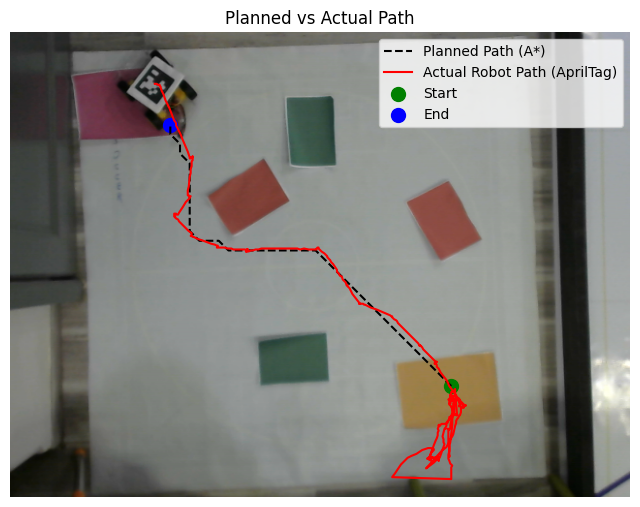

In [12]:
# 2. Plot static maze path and dynamic AprilTag path
maze_x = [p[0] for p in path_pixels]
maze_y = [p[1] for p in path_pixels]

tag_x = [p[0] for p in tag_path]
tag_y = [p[1] for p in tag_path]

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # background image

plt.plot(maze_x, maze_y, 'k--', label='Planned Path (A*)')       # dashed black
plt.plot(tag_x, tag_y, 'r-', label='Actual Robot Path (AprilTag)')  # solid red

if path_pixels:
    plt.scatter(*path_pixels[0], c='green', s=100, label='Start')
    plt.scatter(*path_pixels[-1], c='blue', s=100, label='End')

plt.title("Planned vs Actual Path")
plt.legend()
plt.axis('off')
plt.show()